Saving teams_data.csv to teams_data (16).csv
   team_id   country                      team                                               logo
0    50138     Italy  FC Internazionale Milano  https://img.uefa.com/imgml/TP/teams/logos/70x7...
1    50124     Spain        Atlético de Madrid  https://img.uefa.com/imgml/TP/teams/logos/70x7...
2    50111   Austria             SK Sturm Graz  https://img.uefa.com/imgml/TP/teams/logos/70x7...
3    52816     Italy               Atalanta BC  https://img.uefa.com/imgml/TP/teams/logos/70x7...
4    50050  Scotland                 Celtic FC  https://img.uefa.com/imgml/TP/teams/logos/70x7...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   team_id  36 non-null     int64 
 1   country  36 non-null     object
 2   team     36 non-null     object
 3   logo     36 non-null     object
dtypes: int64(1), object(3)
memory usage: 1

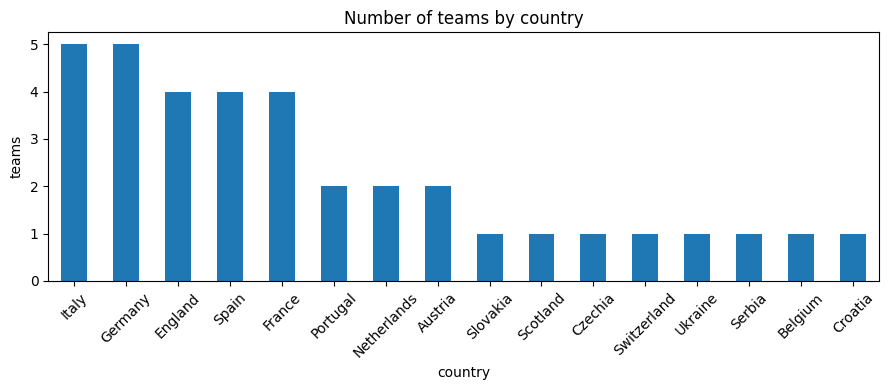

    match_id   season    stage       date                 team             opp_team  gf  ga  team_id  country  \
0          2  2021/22    Group 2021-09-15           Chelsea FC      Manchester City   1   3      NaN      NaN   
1          3  2021/22    Group 2021-09-21    FC Bayern München         Liverpool FC   1   3  50037.0  Germany   
2          3  2021/22    Group 2021-09-21         Liverpool FC    FC Bayern München   3   1   7889.0  England   
3          2  2021/22    Group 2021-09-15      Manchester City           Chelsea FC   3   1  52919.0  England   
4          1  2021/22    Group 2021-09-14  Paris Saint-Germain          Real Madrid   1   2  52747.0   France   
5          1  2021/22    Group 2021-09-14          Real Madrid  Paris Saint-Germain   2   1      NaN      NaN   
6          4  2021/22  Quarter 2021-04-06             AC Milan          Real Madrid   0   2  50058.0    Italy   
7          5  2021/22  Quarter 2021-04-13    FC Bayern München  Paris Saint-Germain   2   2  500

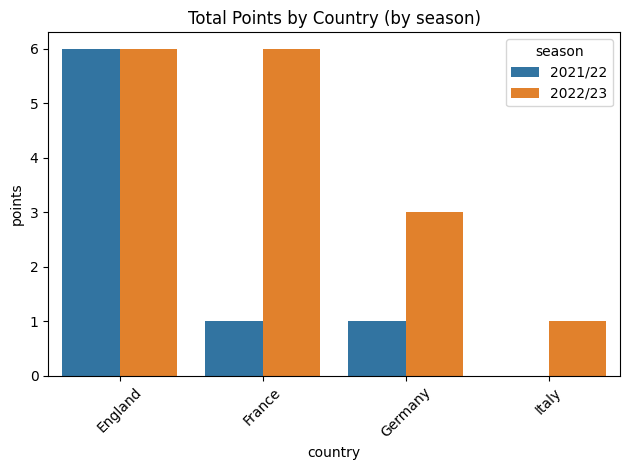

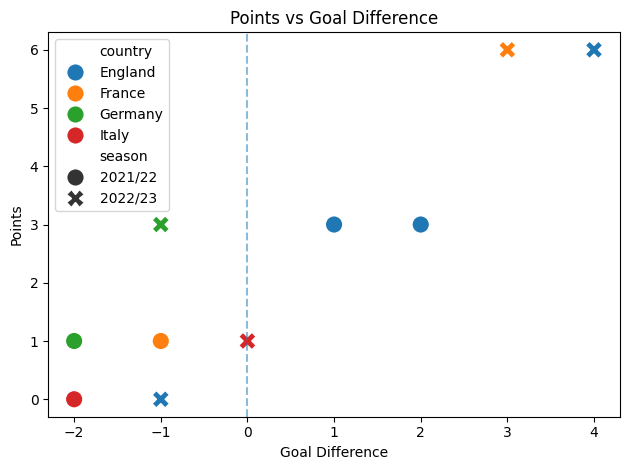

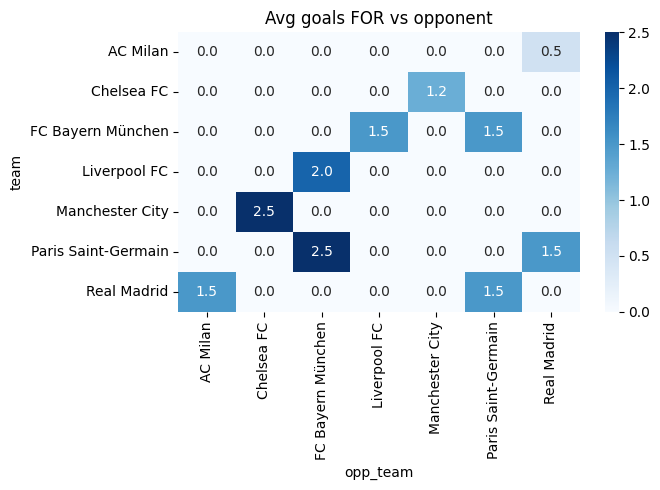

In [17]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.width", 160)
pd.set_option("display.max_rows", 80)

# Upload once per session (choose teams_data.csv)
_ = files.upload()

teams = pd.read_csv("teams_data.csv")
print(teams.head())
print(teams.info())


teams.columns = (teams.columns
                 .str.strip().str.lower().str.replace(" ","_",regex=False))
for c in ["team","country"]:
  teams[c] = teams[c].astype(str).str.strip()

teams = teams.drop_duplicates(subset=["team"]).reset_index(drop=True)

country_counts = teams["country"].value_counts()
country_pct = teams["country"].value_counts(normalize=True).round(3)

print(country_counts.head(10))
print(country_pct.head(10))

country_counts.plot(kind="bar",figsize=(9,4))
plt.title("Number of teams by country")
plt.xlabel("country") ; plt.ylabel("teams"); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

matches = pd.DataFrame({
    "match_id": np.arange(1, 13),
    "season":    ["2021/22"]*6 + ["2022/23"]*6,
    "stage":     ["Group","Group","Group","Quarter","Quarter","Semi"]*2,
    "date": [
        "2021-09-14","2021-09-15","2021-09-21",
        "2021-04-06","2021-04-13","2021-04-27",
        "2022-09-14","2022-09-15","2022-09-21",
        "2022-04-06","2022-04-13","2022-04-27"
    ],
    "home_team": [
        "Real Madrid", "Manchester City", "FC Bayern München",
        "AC Milan", "Paris Saint-Germain", "Chelsea FC",
        "Real Madrid", "Manchester City", "FC Bayern München",
        "AC Milan", "Paris Saint-Germain", "Chelsea FC"
    ],
    "away_team": [
        "Paris Saint-Germain","Chelsea FC","Liverpool FC",
        "Real Madrid","FC Bayern München","Manchester City",
        "Paris Saint-Germain","Chelsea FC","Liverpool FC",
        "Real Madrid","FC Bayern München","Manchester City"
    ],
    "home_goals":[2,3,1,0,2,1, 1,4,2,1,3,2],
    "away_goals":[1,1,3,2,2,0, 2,1,1,1,1,3]
})

matches["date"] = pd.to_datetime(matches["date"], errors="coerce")
matches.head(3)

home = (matches[["match_id","season","stage","date","home_team","away_team","home_goals","away_goals"]]
        .rename(columns={"home_team":"team","away_team":"opp_team","home_goals":"gf","away_goals":"ga"}))

away = (matches[["match_id","season","stage","date","away_team","home_team","away_goals","home_goals"]]
        .rename(columns={"away_team":"team","home_team":"opp_team","away_goals":"gf","home_goals":"ga"}))

long = (pd.concat([home,away],ignore_index=True)
        .sort_values(["season","stage","team","date"])
        .reset_index(drop=True))

long.head()

# ensure teams columns are clean (already done), join on 'team'
long_meta = long.merge(teams.rename(columns={"team":"team_name"}),
                       left_on="team", right_on="team_name", how="left") \
                .drop(columns=["team_name"])

long_meta[["team","country","logo"]].head()

long_meta["result"] = np.select(
    [long_meta["gf"] > long_meta["ga"] , long_meta["gf"] < long_meta["ga"]],
    ["win","loss"],
    default="draw"
)

long_meta["points"] = np.select(
    [long_meta["result"].eq("win"), long_meta["result"].eq("draw")],
    [3,1], default=0
)

print(long_meta)

standings = (long_meta
             .groupby(["season","team","country"], as_index=False)
             .agg(
                 matches=("match_id","count"),
                 wins=("result",  lambda s: (s=="win").sum()),
                 draws=("result", lambda s: (s=="draw").sum()),
                 losses=("result",lambda s: (s=="loss").sum()),
                 gf=("gf","sum"),
                 ga=("ga","sum"),
                 points=("points","sum")
             ))

standings["gd"] = standings["gf"] - standings["ga"]
standings.head()

standings = (standings
             .sort_values(["season","points","gd","gf"], ascending=[True,False,False,False])
             .assign(rank=lambda d: d.groupby("season").cumcount()+1))
standings.head(10)

pts_by_country = (standings.groupby(["season","country"], as_index=False)["points"].sum())
sns.barplot(data=pts_by_country,x="country",y="points",hue="season")
plt.xticks(rotation=45); plt.title("Total Points by Country (by season)")
plt.tight_layout(); plt.show()

sns.scatterplot(data=standings,x="gd",y="points",hue="country",style="season",s=160)
plt.axvline(0, ls="--", alpha=0.5); plt.title("Points vs Goal Difference")
plt.xlabel("Goal Difference"); plt.ylabel("Points")
plt.tight_layout(); plt.show()

matrix_for = pd.pivot_table(
    long, values="gf", index="team", columns="opp_team",
    aggfunc="mean", fill_value=0
)
plt.figure(figsize=(7,5))
sns.heatmap(matrix_for, annot=True, fmt=".1f", cmap="Blues")
plt.title("Avg goals FOR vs opponent"); plt.tight_layout(); plt.show()



